# Introduction

In this Task we will continue to imagine that we are in a lab studying the newly sequenced Thermofilum sp. NZ13-TE1 strain. After the success of the EGFP knockdown experiment we are tasked with creating a protospacer library containing 5 protospacers targeting each gene with minimal off-target effects.

In [13]:
import sys
sys.path.append('../')
import crisprtree
from crisprtree import utils
from crisprtree import estimators
from crisprtree import annotators

In [22]:
from Bio import SeqIO
from Bio.Seq import reverse_complement
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
from scipy.stats import hmean

sbn.set(style = 'white', font_scale=1.5)
%matplotlib inline


# Load sequences

Standard Biopython tools can be used to load the Thermofilum sp. NZ13-TE1 genome and the AddGene plasmid.

In [15]:
with open('data/GCA_002855745.1_ASM285574v1_genomic.gbff') as handle:
    genome = list(SeqIO.parse(handle, 'genbank'))[0]

# Algorithm

The `crisprtree` library allows us to use a simple algorithm.

`for each gene in Thermofilum:`
    1. Extract possible targets
    2. Scan the genome (minus the target gene) for off-target hits
    3. Exclude high-risk protospacers
    4. Save 5 that pass the filter
    
    

In [31]:
estimator = estimators.CFDEstimator.build_pipeline()

library_grnas = []

gene_info = []

for feat in genome.features:
    if feat.type == 'CDS':
        # Only target genes
        
        # Get info about this gene
        product = feat.qualifiers['product'][0]
        tag = feat.qualifiers['locus_tag'][0]
        gene_record = feat.extract(genome)
        
        # Get protospacers
        possible_targets = utils.extract_possible_targets(gene_record)
        
        # Score off-target hits
        genome_minus_gene = genome[:feat.location.start] + genome[feat.location.end:]
        possible_binding = utils.cas_offinder(possible_targets, 5, seqs = [genome_minus_gene])
        possible_binding['Score'] = estimator.predict_proba(possible_binding.values)
        
        # Aggregate and sort off-target scan
        offtarget_scores = possible_binding.groupby('gRNA')['Score'].agg('max')
        offtarget_scores.sort_values(inplace=True)
        
        
        # Save information
        gene_info.append({'Product': product,
                          'Tag': tag,
                          'UsefulGuides': (offtarget_scores<=0.25).sum()})
        
        
        for protospacer, off_score in offtarget_scores.head().to_dict().items():
            location = genome.seq.find(protospacer)
            strand = '+'
            if location == -1:
                location = genome.seq.find(reverse_complement(protospacer))
                strand = '-'

            library_grnas.append({'Product': product,
                                  'Tag': tag,
                                  'Protospacer': protospacer,
                                  'Location': location,
                                  'Strand': strand,
                                  'Off Target Score': off_score})
            
gene_df = pd.DataFrame(gene_info)
        
library_df = pd.DataFrame(library_grnas)

# Sucess?

Our goal was to create 5 protospacers for each gene. Were we able to?

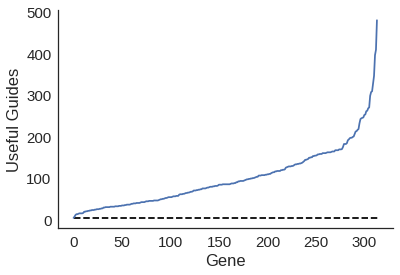

In [35]:
useful_guides = gene_df['UsefulGuides'].sort_values()
fig, ax = plt.subplots(1,1)
ax.plot(useful_guides.values)
ax.set_ylabel('Useful Guides')
ax.set_xlabel('Gene')
ax.hlines(5, 0, len(useful_guides), linestyle = '--')
sbn.despine(ax=ax)

In [34]:
gene_df.query('UsefulGuides < 5')

,Product,Tag,UsefulGuides
150,hypothetical protein,B7L53_00760,4


Only 1 hypothetical protein had fewer than 5 useful targets.